#### Referência: https://medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
import time
from matplotlib import style
import itertools as it
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
def normalize(z, mean, std, eps=1e-12):
    return (z - mean)/(std + eps)

### Carregando Dados

In [3]:
train = np.load('./mini_cinic10/train.npz')
val = np.load('./mini_cinic10/val.npz')
test = np.load('./mini_cinic10/test.npz')

In [4]:
X_train_norm = normalize(train['xs'], train['xs'].mean(), train['xs'].std()) 
X_val_norm = normalize(val['xs'], val['xs'].mean(), val['xs'].std()) 
X_test_norm = normalize(test['xs'], test['xs'].mean(), test['xs'].std())

In [5]:
#Train
num_rows, num_cols = X_train_norm.shape
Y_train = train['ys'][:num_rows]
X_train = np.ones((num_rows, num_cols + 1))
X_train[:,1:] = X_train_norm[:num_rows]

In [6]:
#Validation
num_rows, num_cols = X_val_norm.shape
Y_val = val['ys'][:num_rows]
X_val = np.ones((num_rows, num_cols + 1))
X_val[:,1:] = X_val_norm[:num_rows]

In [7]:
#Test
num_rows, num_cols = X_test_norm.shape
Y_test = test['ys'][:num_rows]
X_test = np.ones((num_rows, num_cols + 1))
X_test[:,1:] = X_test_norm[:num_rows]

### Funções

In [8]:
def softmax(x):
    x -= np.max(x)
    sm = (np.exp(x).T / np.sum(np.exp(x), axis=1)).T
    return sm

In [9]:
def log(z, eps=1e-32):
    return np.log(np.maximum(z, eps))

In [10]:
def OneHotEncoding(y):
    m = y.shape[0]
    M = scipy.sparse.csr_matrix((np.ones(m), (y, np.array(range(m)))))
    M = np.array(M.todense()).T
    return M

In [11]:
def ProbsAndPreds(x):
    probs = softmax(np.dot(x,theta)) #Aplica softmax para obter a probabilidade
    preds = np.argmax(probs,axis=1) #Resultado da predição, retorna o valor relacionado à maior probabilidade
    return probs,preds

In [12]:
def getLoss(theta,x,y):
    m = x.shape[0] #Numero de entradas
    y = OneHotEncoding(y) #Transforma as classes de Y de inteiro para vetor de 0s e 1s
    prob = ProbsAndPreds(x)[0] 
    loss = (-1 / m) * np.sum(y * log(prob) + (1-y) * log(1 - prob)) #Erro das probabilidades
    grad = (-1 / m) * np.dot(x.T,(y - prob)) #Computa o gradiente para o erro
    return loss,grad

In [13]:
def random_theta(size1, size2, rand_seed=None):
    rand = np.random.RandomState(seed=rand_seed)
    sigma = np.sqrt(2/(size1 + size2))
    return sigma*rand.randn(size1, size2)

In [14]:
def zero_theta(size1, size2):
    return np.zeros(shape=(size1, size2)).astype('float32')

In [15]:
def accuracy(x, y):
    pred = ProbsAndPreds(x)[1]
    accuracy = sum(pred == y)/(float(len(y)))
    return accuracy

### Loop Principal

In [16]:
theta = random_theta(X_train.shape[1],len(np.unique(Y_train)))
epochs = 5000
batch = 100
iterations = len(Y_train)//batch
learningRate = 1e-4
train_losses = []
val_losses = []
start_time = time.time()
for i in range(epochs):
    for j in range(iterations):
        loss,grad = getLoss(theta,X_train[j*batch:(j+1)*batch],Y_train[j*batch:(j+1)*batch])
        theta = theta - (learningRate * grad)
    train_losses.append(loss)
    loss, grad = getLoss(theta, X_val, Y_val)
    val_losses.append(loss)
    if (i % (epochs/10) == 0):
        print("{}%".format(i*100/epochs))
total_time = time.time() - start_time
print("Trainned in {} seconds".format(total_time))

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
Trainned in 3972.5807135105133 seconds


Text(0.5, 1.0, 'Loss x Epochs')

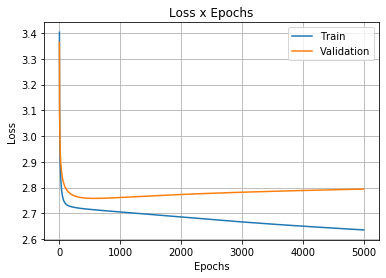

In [19]:
plt.plot(train_losses, label = "Train")
plt.plot(val_losses, label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.title("Loss x Epochs")
plt.savefig("matrix.eps")

In [18]:
print('Training Accuracy:', accuracy(X_train, Y_train))
print('Validation Accuracy:', accuracy(X_val, Y_val))
print('Test Accuracy:', accuracy(X_test, Y_test))

Training Accuracy: 0.399325
Validation Accuracy: 0.329
Test Accuracy: 0.3178


In [20]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix
[[507  68  61  20  30  27  12  59 162  85]
 [ 59 367  43  49  20  44  57  57  74 195]
 [112  44 184  75  99 102 128  61 106  21]
 [ 37  72 114 216  56 169 164  64  48  44]
 [ 58  52 114  83 248 110 135 141  40  60]
 [ 49  69  91 194  88 176 125 106  54  48]
 [ 25  50  99 144 103 108 404  54  29  22]
 [ 38  57  67  73 113  81  54 379  42  91]
 [194  70  86  44  24  34  29  35 366 123]
 [100 235  38  26  20  37  42  79 101 331]]


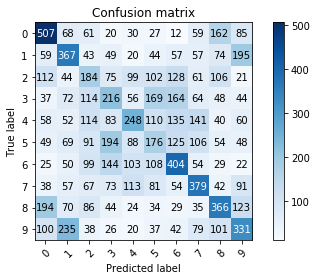

In [21]:
plot_confusion_matrix(Y_test, ProbsAndPreds(X_test)[1], np.unique(Y_test),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)
plt.savefig("matrix.eps")

# Neural Network with 1 Hidden Layer

In [ ]:
train = np.load('./mini_cinic10/train.npz')
val = np.load('./mini_cinic10/val.npz')

In [ ]:
X_train_norm = normalize(train['xs'], train['xs'].mean(), train['xs'].std()) 
X_val_norm = normalize(val['xs'], val['xs'].mean(), val['xs'].std()) 

In [ ]:
X_train_norm.shape # 80k samples 3072 features

In [ ]:
# Samples
num_samples = 500

In [ ]:
# Input Vector
a1 = X_train_norm.T[:,:num_samples]

In [ ]:
# Target Vector
y = train['ys'][:num_samples]
y = OneHotEncoding(y).T

In [ ]:
# Validation Data
val_a1 = X_val_norm.T[:,:num_samples]
val_y = val['ys'][:num_samples]
val_y = OneHotEncoding(val_y).T

In [ ]:
def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x > 0).astype(int)

def xent(out, y):
    return -np.sum(y*log(out))

def sm(x):
    exps = np.exp(x - np.max(x))
    return exps/np.sum(exps)

In [ ]:
# Main Loop
epochs = 50

# Theta
# Theta1 = from input to hidden layer
num_features = a1.shape[0]
num_hidden_layers = 10**3
theta1 = random_theta(num_hidden_layers, num_features)

#Theta2 = From Hidden Layer to output layer
num_classes = y.shape[0]
theta2 = random_theta(num_classes, num_hidden_layers)

# Bias
b1 = np.random.randn(num_hidden_layers, num_samples)
b2 = np.random.randn(num_classes, num_samples)

# Learning Rate
lr = 0.1

# Cost Function History
train_c = []
val_c = []

start_time = time.time()
for i in range(epochs):
    
    # Forwarding
    z2 = theta1.dot(a1)+b1
    a2 = relu(z2)
    z3 = theta2.dot(a2)+b2
    a3 = sm(z3)

    # Cost Function
    train_c.append(xent(a3, y))

    val_z2 = theta1.dot(val_a1)+b1
    val_a2 = relu(val_z2)
    val_z3 = theta2.dot(val_a2)+b2
    val_a3 = sm(val_z3)
    val_c.append(xent(val_a3, val_y))

    # Backpropagation
    delta_3 = a3 - y
    delta_2 = theta2.T.dot(delta_3) * drelu(z2)

    # Gradient
    C_theta2 = delta_3.dot(a2.T)
    C_theta1 = delta_2.dot(a1.T)

    # Learn
    theta1 = theta1 - lr * C_theta1/num_samples
    theta2 = theta2 - lr * C_theta2/num_samples
    b1 = b1 - lr * delta_2/num_samples
    b2 = b2 - lr * delta_3/num_samples

    if (i % (epochs/10) == 0):
        print("{}%".format(i*100/epochs))
total_time = time.time() - start_time
print("Trainned in {} seconds".format(total_time))

In [ ]:
plt.plot(train_c, "r")
plt.plot(val_c, "b")
plt.show()